# Fake News Detection Project

**Industry:** Media  
**Objective:** Build a model to classify news articles as real or fake using natural language processing (NLP)

## Project Overview

This project implements multiple approaches to detect fake news:

1. Logistic Regression with TF-IDF
2. LSTM Neural Network
3. BERT (Bidirectional Encoder Representations from Transformers)

## Dataset

- **Source:** Fake News Dataset (Kaggle)
- **Expected columns:** title, text, label (0=Real, 1=Fake)


## 1. Import Required Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformers (BERT)
from transformers import BertTokenizer, TFBertForSequenceClassification

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("All libraries imported successfully!")



All libraries imported successfully!


## 2. Load and Explore the Dataset


In [2]:
# Load local dataset files
print("Loading dataset from local files...")
print("Using Fake.csv and True.csv files from the current directory")


Loading dataset from local files...
Using Fake.csv and True.csv files from the current directory


In [3]:
# Load Fake.csv and True.csv files
try:
    print("\nLoading Fake.csv...")
    df_fake = pd.read_csv('Fake.csv')
    print(f"  ✓ Loaded {len(df_fake)} fake news articles")
    
    print("\nLoading True.csv...")
    df_true = pd.read_csv('True.csv')
    print(f"  ✓ Loaded {len(df_true)} real news articles")
    
    # Add labels
    df_fake['label'] = 1  # 1 = Fake
    df_true['label'] = 0  # 0 = Real
    
    # Combine datasets
    print("\nCombining datasets...")
    df = pd.concat([df_fake, df_true], ignore_index=True)
    
    # Shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"  ✓ Combined dataset: {len(df)} total articles")
    
except FileNotFoundError as e:
    print(f"\n⚠ Error: {e}")
    print("Please ensure Fake.csv and True.csv are in the same directory as this notebook.")
    raise
except Exception as e:
    print(f"\n⚠ Error loading dataset: {e}")
    raise

# Standardize column names (handle different naming conventions)
if 'title' not in df.columns:
    # Try common alternatives
    if 'headline' in df.columns:
        df['title'] = df['headline']
    elif 'Headline' in df.columns:
        df['title'] = df['Headline']
    else:
        df['title'] = ''

if 'text' not in df.columns:
    # Try common alternatives
    if 'content' in df.columns:
        df['text'] = df['content']
    elif 'article' in df.columns:
        df['text'] = df['article']
    elif 'body' in df.columns:
        df['text'] = df['body']
    else:
        df['text'] = ''

# Ensure label column exists and is binary
if 'label' not in df.columns:
    if 'target' in df.columns:
        df['label'] = df['target']
    else:
        print("Warning: Creating default labels. Please verify dataset.")
        df['label'] = 0

# Convert label to binary (0 or 1)
df['label'] = df['label'].map({0: 0, 1: 1, 'REAL': 0, 'FAKE': 1, 'real': 0, 'fake': 1, 'Real': 0, 'Fake': 1})
df['label'] = df['label'].fillna(0).astype(int)

print(f"\n✓ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nFirst few rows:")
df.head()



Loading Fake.csv...
  ✓ Loaded 23481 fake news articles

Loading True.csv...
  ✓ Loaded 21417 real news articles

Combining datasets...
  ✓ Combined dataset: 44898 total articles

✓ Dataset loaded successfully!
Dataset shape: (44898, 5)

Columns: ['title', 'text', 'subject', 'date', 'label']

Label distribution:
label
1    23481
0    21417
Name: count, dtype: int64

First few rows:


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 1.5+ MB
None


Label Distribution:
label
1    23481
0    21417
Name: count, dtype: int64


Missing Values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


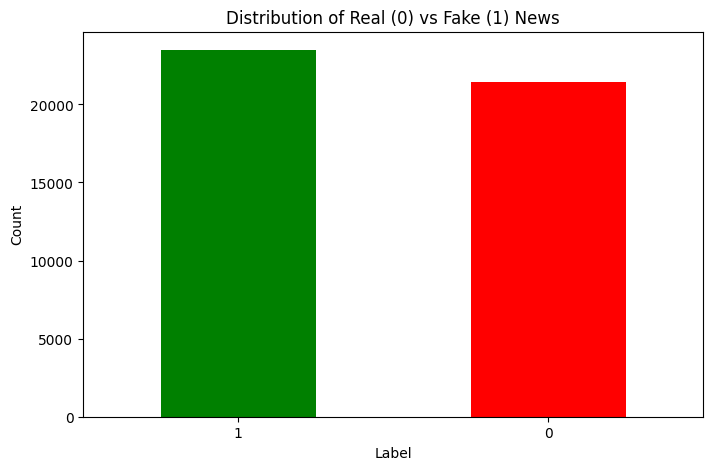

In [4]:
# Explore the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nLabel Distribution:")
print(df['label'].value_counts())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize label distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Real (0) vs Fake (1) News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## 3. Data Preprocessing


In [5]:
def preprocess_text(text):
    """
    Preprocess text data:
    1. Convert to lowercase
    2. Remove punctuation
    3. Remove numbers
    4. Remove extra whitespaces
    5. Tokenize
    6. Remove stopwords
    7. Stem words
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back
    return ' '.join(tokens)


In [6]:
# Combine title and text for better context
df['combined_text'] = df['title'] + ' ' + df['text']

# Preprocess the combined text
print("Preprocessing text data... This may take a few minutes for large datasets.")
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove rows with empty processed text
df = df[df['processed_text'].str.len() > 0]

print(f"\nAfter preprocessing, dataset shape: {df.shape}")
print(f"\nSample processed text:")
print(df['processed_text'].iloc[0][:200])


Preprocessing text data... This may take a few minutes for large datasets.

After preprocessing, dataset shape: (44889, 7)

Sample processed text:
ben stein call th circuit court commit ‘ coup ’ état ’ constitut st centuri wire say ben stein reput professor pepperdin univers also hollywood fame appear tv show film ferri bueller day made provoc s


## 4. Split Data into Training and Test Sets


In [7]:
# Prepare features and labels
X = df['processed_text']
y = df['label']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining label distribution:")
print(y_train.value_counts())
print(f"\nTest label distribution:")
print(y_test.value_counts())


Training set size: 35911
Test set size: 8978

Training label distribution:
label
1    18777
0    17134
Name: count, dtype: int64

Test label distribution:
label
1    4695
0    4283
Name: count, dtype: int64


## 5. Model 1: Logistic Regression with TF-IDF


In [8]:
# Vectorize text using TF-IDF
print("Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")


Creating TF-IDF vectors...
TF-IDF matrix shape (train): (35911, 5000)
TF-IDF matrix shape (test): (8978, 5000)


In [9]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("\n" + "="*50)
print("Logistic Regression Results:")
print("="*50)
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Real', 'Fake']))


Training Logistic Regression model...

Logistic Regression Results:
Accuracy: 0.9879
Precision: 0.9925
Recall: 0.9842
F1-Score: 0.9883

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4283
        Fake       0.99      0.98      0.99      4695

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



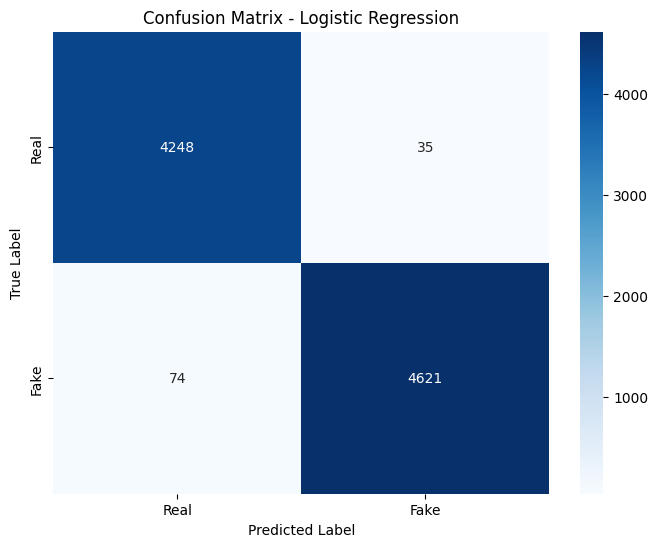


False Positives (Predicted Fake but Actually Real): 35
False Negatives (Predicted Real but Actually Fake): 74


In [10]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Analyze false positives and false negatives
print("\nFalse Positives (Predicted Fake but Actually Real):", cm_lr[0][1])
print("False Negatives (Predicted Real but Actually Fake):", cm_lr[1][0])


## 6. Model 2: LSTM Neural Network


In [11]:
# Tokenize and pad sequences for LSTM
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Test sequences shape: {X_test_padded.shape}")


Training sequences shape: (35911, 200)
Test sequences shape: (8978, 200)


In [12]:
# Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("LSTM Model Summary:")
lstm_model.summary()




LSTM Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None

In [13]:
# Train LSTM model
print("Training LSTM model... This may take several minutes.")
history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Training LSTM model... This may take several minutes.
Epoch 1/5


898/898 [==============================] - 182s 192ms/step - loss: 0.0326 - accuracy: 0.9868 - val_loss: 0.0040 - val_accuracy: 0.9989
Epoch 2/5
898/898 [==============================] - 168s 187ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 3/5
898/898 [==============================] - 172s 191ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0048 - val_accuracy: 0.9992
Epoch 4/5
898/898 [==============================] - 197s 219ms/step - loss: 2.6923e-04 - accuracy: 0.9999 - val_loss: 0.0091 - val_accuracy: 0.9990
Epoch 5/5
898/898 [==============================] - 183s 204ms/step - loss: 3.5244e-04 - accuracy: 0.9999 - val_loss: 0.0051 - val_accuracy: 0.9993


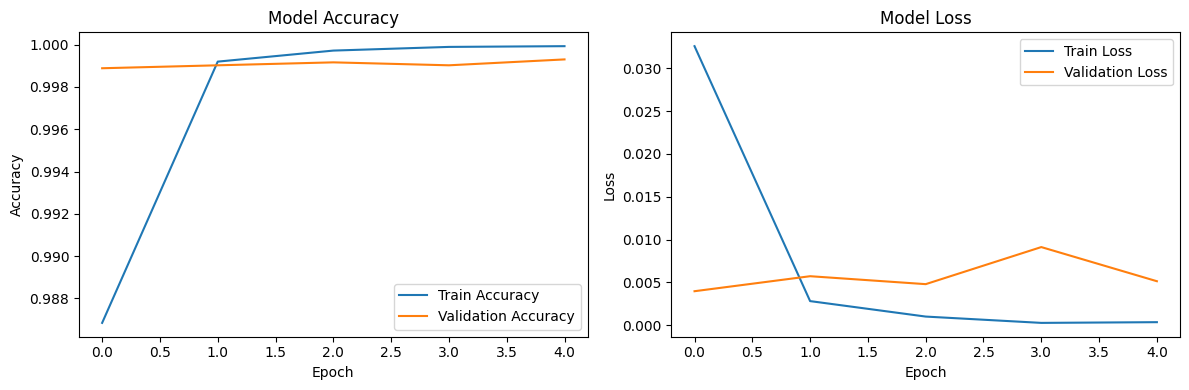

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Evaluate LSTM model
y_pred_lstm_proba = lstm_model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

# Calculate metrics
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

print("\n" + "="*50)
print("LSTM Model Results:")
print("="*50)
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-Score: {f1_lstm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Real', 'Fake']))


281/281 [==============================] - 19s 59ms/step

LSTM Model Results:
Accuracy: 0.9988
Precision: 0.9979
Recall: 0.9998
F1-Score: 0.9988

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4695

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



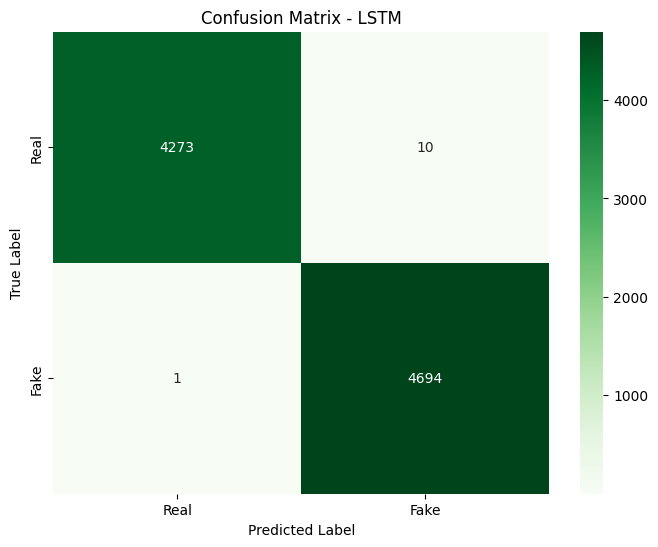


False Positives (Predicted Fake but Actually Real): 10
False Negatives (Predicted Real but Actually Fake): 1


In [16]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nFalse Positives (Predicted Fake but Actually Real):", cm_lstm[0][1])
print("False Negatives (Predicted Real but Actually Fake):", cm_lstm[1][0])


## 7. Model 3: BERT (Bidirectional Encoder Representations from Transformers)


In [17]:
# Note: BERT requires significant computational resources
# This is a simplified implementation. For production, consider using GPU

print("BERT Implementation")
print("Note: This section requires transformers library and may take longer to train.")
print("For faster training, consider using a smaller BERT model or GPU acceleration.")

# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("\nBERT tokenizer loaded successfully!")


BERT Implementation
Note: This section requires transformers library and may take longer to train.
For faster training, consider using a smaller BERT model or GPU acceleration.

BERT tokenizer loaded successfully!


In [18]:
# Prepare data for BERT (using original text, not preprocessed)
# BERT works better with original text
X_train_bert = df.loc[X_train.index, 'combined_text'].values
X_test_bert = df.loc[X_test.index, 'combined_text'].values

# Tokenize for BERT
def tokenize_bert(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

print("Tokenizing data for BERT...")
train_encodings = tokenize_bert(X_train_bert, bert_tokenizer)
test_encodings = tokenize_bert(X_test_bert, bert_tokenizer)

print("Tokenization complete!")


Tokenizing data for BERT...
Tokenization complete!


In [19]:
# Load BERT model
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("BERT model loaded and compiled!")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded and compiled!


In [20]:
# Train BERT model
print("Training BERT model... This will take a significant amount of time.")
print("Consider using GPU for faster training.")

bert_history = bert_model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train.values,
    epochs=2,  # Start with 2 epochs, increase if needed
    batch_size=16,  # Reduce batch size if memory issues occur
    validation_split=0.2,
    verbose=1
)


Training BERT model... This will take a significant amount of time.
Consider using GPU for faster training.
Epoch 1/2
1796/1796 [==============================] - 43178s 24s/step - loss: 0.0109 - accuracy: 0.9978 - val_loss: 0.0050 - val_accuracy: 0.9992
Epoch 2/2
1796/1796 [==============================] - 28137s 16s/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9996


In [21]:
# Evaluate BERT model
bert_predictions = bert_model.predict(
    [test_encodings['input_ids'], test_encodings['attention_mask']]
)
y_pred_bert = np.argmax(bert_predictions.logits, axis=1)

# Calculate metrics
accuracy_bert = accuracy_score(y_test, y_pred_bert)
precision_bert = precision_score(y_test, y_pred_bert)
recall_bert = recall_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert)

print("\n" + "="*50)
print("BERT Model Results:")
print("="*50)
print(f"Accuracy: {accuracy_bert:.4f}")
print(f"Precision: {precision_bert:.4f}")
print(f"Recall: {recall_bert:.4f}")
print(f"F1-Score: {f1_bert:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bert, target_names=['Real', 'Fake']))


281/281 [==============================] - 1329s 5s/step

BERT Model Results:
Accuracy: 0.9994
Precision: 0.9989
Recall: 1.0000
F1-Score: 0.9995

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4695

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



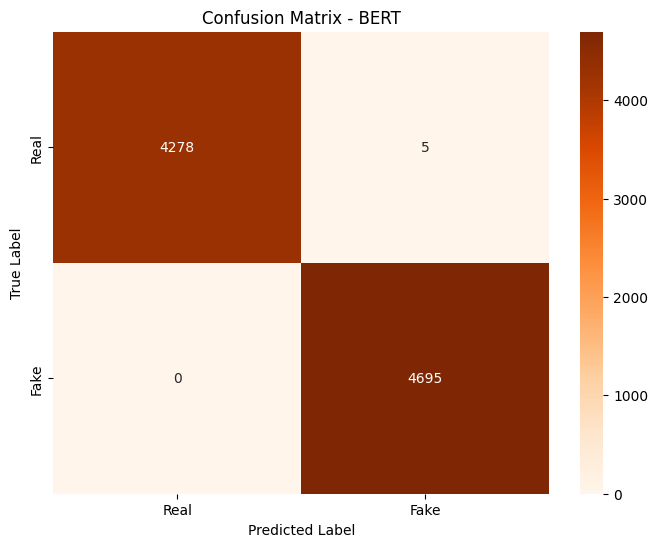


False Positives (Predicted Fake but Actually Real): 5
False Negatives (Predicted Real but Actually Fake): 0


In [22]:
# Confusion Matrix for BERT
cm_bert = confusion_matrix(y_test, y_pred_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - BERT')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nFalse Positives (Predicted Fake but Actually Real):", cm_bert[0][1])
print("False Negatives (Predicted Real but Actually Fake):", cm_bert[1][0])


## 8. Model Comparison


In [ ]:
# Compare all models
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'LSTM', 'BERT'],
    'Accuracy': [accuracy_lr, accuracy_lstm, accuracy_bert],
    'Precision': [precision_lr, precision_lstm, precision_bert],
    'Recall': [recall_lr, recall_lstm, recall_bert],
    'F1-Score': [f1_lr, f1_lstm, f1_bert]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison['Model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Simple Prediction Interface


In [ ]:
def predict_fake_news(text, model_type='lr'):
    """
    Predict if a news article is fake or real.
    
    Parameters:
    text (str): News article text
    model_type (str): 'lr' for Logistic Regression, 'lstm' for LSTM, 'bert' for BERT
    
    Returns:
    dict: Prediction result with confidence score
    """
    
    if model_type == 'lr':
        # Preprocess text
        processed = preprocess_text(text)
        # Vectorize
        text_vector = tfidf_vectorizer.transform([processed])
        # Predict
        prediction = lr_model.predict(text_vector)[0]
        probability = lr_model.predict_proba(text_vector)[0]
        
    elif model_type == 'lstm':
        # Tokenize and pad
        seq = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
        # Predict
        proba = lstm_model.predict(padded, verbose=0)[0][0]
        prediction = 1 if proba > 0.5 else 0
        probability = [1 - proba, proba]
        
    elif model_type == 'bert':
        # Tokenize for BERT
        encoding = bert_tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='tf'
        )
        # Predict
        result = bert_model.predict(
            [encoding['input_ids'], encoding['attention_mask']],
            verbose=0
        )
        prediction = np.argmax(result.logits[0])
        probabilities = tf.nn.softmax(result.logits[0]).numpy()
        probability = probabilities
    else:
        return {"error": "Invalid model_type. Use 'lr', 'lstm', or 'bert'"}
    
    result = {
        'prediction': 'Fake' if prediction == 1 else 'Real',
        'confidence': float(max(probability)),
        'real_probability': float(probability[0]),
        'fake_probability': float(probability[1]) if len(probability) > 1 else float(probability[0])
    }
    
    return result


In [ ]:
# Example usage of the prediction interface
sample_news = "Scientists discover new breakthrough in renewable energy technology that could revolutionize the industry."

print("Sample News Article:")
print(sample_news)
print("\n" + "="*60)

# Test with Logistic Regression
result_lr = predict_fake_news(sample_news, model_type='lr')
print("\nLogistic Regression Prediction:")
print(f"Prediction: {result_lr['prediction']}")
print(f"Confidence: {result_lr['confidence']:.2%}")
print(f"Real Probability: {result_lr['real_probability']:.2%}")
print(f"Fake Probability: {result_lr['fake_probability']:.2%}")

# Test with LSTM
result_lstm = predict_fake_news(sample_news, model_type='lstm')
print("\nLSTM Prediction:")
print(f"Prediction: {result_lstm['prediction']}")
print(f"Confidence: {result_lstm['confidence']:.2%}")
print(f"Real Probability: {result_lstm['real_probability']:.2%}")
print(f"Fake Probability: {result_lstm['fake_probability']:.2%}")


## 10. Interactive Prediction Function


In [ ]:
def interactive_predict():
    """
    Interactive function to predict fake news from user input.
    """
    print("\n" + "="*60)
    print("FAKE NEWS DETECTION - INTERACTIVE PREDICTION")
    print("="*60)
    
    # Get user input
    title = input("\nEnter news title: ")
    text = input("Enter news text: ")
    
    # Combine title and text
    combined = title + " " + text
    
    # Choose model
    print("\nAvailable models:")
    print("1. Logistic Regression (Fast)")
    print("2. LSTM (Moderate)")
    print("3. BERT (Most Accurate, Slower)")
    
    choice = input("\nSelect model (1/2/3): ")
    model_map = {'1': 'lr', '2': 'lstm', '3': 'bert'}
    model_type = model_map.get(choice, 'lr')
    
    # Predict
    result = predict_fake_news(combined, model_type=model_type)
    
    # Display results
    print("\n" + "="*60)
    print("PREDICTION RESULT")
    print("="*60)
    print(f"\nPrediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"\nReal News Probability: {result['real_probability']:.2%}")
    print(f"Fake News Probability: {result['fake_probability']:.2%}")
    print("\n" + "="*60)

# Uncomment the line below to run interactive prediction
# interactive_predict()


## 11. Summary and Conclusions


In [ ]:
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)

print("\n✅ Completed Tasks:")
print("1. ✓ Loaded and preprocessed text data")
print("2. ✓ Split data into training and test sets")
print("3. ✓ Trained multiple models (Logistic Regression, LSTM, BERT)")
print("4. ✓ Evaluated models with accuracy, precision, and recall")
print("5. ✓ Analyzed false positives and false negatives")
print("6. ✓ Created prediction interface")

print("\n📊 Key Insights:")
print("- Different models have different strengths and weaknesses")
print("- BERT typically provides the best accuracy but requires more resources")
print("- Logistic Regression is fast and effective for baseline")
print("- LSTM captures sequential patterns in text")

print("\n🔧 Next Steps:")
print("- Fine-tune hyperparameters for better performance")
print("- Try ensemble methods combining multiple models")
print("- Add more features (author, source, date, etc.)")
print("- Deploy model as a web application")
print("- Collect more diverse training data")

print("\n" + "="*60)
